**Sentiment Analysis** is also known as "Opinion mining" or "emotion AI". It is a branch of Natural Language Processing and text analytics. It is used to systematically identify, extract, quantify, and study effective states and subjective information. This kind of analysis is widely applied to analyse the attitude of the customer. Data extracted via online survey, social media feeds like Twitter, Facebook, YouTube Comments, Reddit, etc can be used as a data source.

The output would be either **Positive, Negative or Neutral**.

In [0]:
# loading required libraries
import mlflow
import numpy as np
import pandas as pd
from xgboost import XGBClassifier

import sklearn
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

### Load Data

Data required to train the model is loaded into Spark Dataframe

In [0]:
## load data from SQL table
df_loaded = spark.read.format("csv").option("header",True).load('/mnt/data-source/TwitterSentiment/ADBTwitterData.csv')
# Preview data
df_loaded = df_loaded.toPandas()

### Select supported columns
This allows us to train a model that can predict on a dataset that has extra columns that are not used in training.
`[]` are dropped in the pipelines.

In [0]:
from databricks.automl_runtime.sklearn.column_selector import ColumnSelector
supported_cols = ["twitter_text"]
col_selector = ColumnSelector(supported_cols)

## Preprocessors
*Text features*: Convert each feature to a fixed-length vector using TF-IDF vectorization. Each column corresponds to one of the top word n-grams
where n is in the range [1, 2].
Term Frequency — Inverse Document Frequency (TFIDF) is a technique for text vectorization based on the Bag of words (BoW) model. It performs better than the BoW model as it considers the importance of the word in a document into consideration.

In [0]:
transformers = []

for col in {'twitter_text'}:
    vectorizer = Pipeline(steps=[
        ("imputer", SimpleImputer(missing_values=None, strategy="constant", fill_value="")),
        # Reshape to 1D since SimpleImputer changes the shape of the input to 2D
        ("reshape", FunctionTransformer(np.reshape, kw_args={"newshape":-1})),
        ("tfidf", TfidfVectorizer(decode_error="ignore", ngram_range = (1, 2), max_features=1024))])

    transformers.append((f"text_{col}", vectorizer, [col]))
    
preprocessor = ColumnTransformer(transformers, remainder="passthrough", sparse_threshold=0)

## Train - Validation - Test Split
Split the input data into 3 sets:
- Train (60% of the dataset used to train the model)
- Validation (20% of the dataset used to tune the hyperparameters of the model)
- Test (20% of the dataset used to report the true performance of the model on an unseen dataset)

In [0]:
target_col = "sentiment"
split_X = df_loaded.drop([target_col], axis=1)
split_y = df_loaded[target_col]

# Split out train data
X_train, split_X_rem, y_train, split_y_rem = train_test_split(split_X, split_y, train_size=0.6, random_state=663594782, stratify=split_y)

# Split remaining data equally for validation and test
X_val, X_test, y_val, y_test = train_test_split(split_X_rem, split_y_rem, test_size=0.5, random_state=663594782, stratify=split_y_rem)

## Train classification model (XGboost model)
- Log relevant metrics to MLflow to track runs
- All the runs are logged under [this MLflow experiment](#mlflow/experiments/544873084077857/s?orderByKey=metrics.%60val_accuracy_score%60&orderByAsc=false)
- Change the model parameters and re-run the training cell to log a different trial to the MLflow experiment
- To view the full list of tuneable hyperparameters, check the output of the cell below

In [0]:
set_config(display="diagram")

# below set of parameters identified from databricks AutoML runs to select optimal parameters to get best model
xgbc_classifier = XGBClassifier(
  colsample_bytree=0.21229231550668443,
  learning_rate=0.10252160457675814,
  max_depth=4,
  min_child_weight=16,
  n_estimators=1116,
  n_jobs=100,
  subsample=0.5305753578345198,
  verbosity=0,
  random_state=663594782,
)

# ML model pipeline configaration
model = Pipeline([
    ("column_selector", col_selector),
    ("preprocessor", preprocessor),
    ("classifier", xgbc_classifier),
])

# Create a separate pipeline to transform the validation dataset. This is used for early stopping.
pipeline = Pipeline([
    ("column_selector", col_selector),
    ("preprocessor", preprocessor),
])

mlflow.sklearn.autolog(disable=True)
pipeline.fit(X_train, y_train)
X_val_processed = pipeline.transform(X_val)

model

Pipeline Pipeline(steps=[('column_selector', ColumnSelector(cols=['twitter_text'])),
 ('preprocessor',
 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
 transformers=[('text_twitter_text',
 Pipeline(steps=[('imputer',
 SimpleImputer(fill_value='',
 missing_values=None,
 strategy='constant')),
 ('reshape',
 FunctionTransformer(func=<function reshape at 0x7f61bacb0f7...
 learning_rate=0.10252160457675814,
 max_delta_step=None, max_depth=4,
 min_child_weight=16, missing=nan,
 monotone_constraints=None, n_estimators=1116,
 n_jobs=100, num_parallel_tree=None,
 predictor=None, random_state=663594782,
 reg_alpha=None, reg_lambda=None,
 scale_pos_weight=None,
 subsample=0.5305753578345198, tree_method=None,
 validate_parameters=None, verbosity=0))]) ColumnSelector ColumnSelector(cols=['twitter_text']) preprocessor: ColumnTransformer ColumnTransformer(remainder='passthrough', sparse_threshold=0,
 transformers=[('text_twitter_text',
 Pipeline(steps=[('imputer',
 SimpleImputer(fill_value='',
 missing_values=None,
 strategy='constant')),
 ('reshape',
 FunctionTransformer(func= ,
 kw_args={'newshape': -1})),
 ('tfidf',
 TfidfVectorizer(decode_error='ignore',
 max_features=1024,
 ngram_range=(1,
 2)))]),
 ['twitter_text'])]) text_twitter_text ['twitter_text'] SimpleImputer SimpleImputer(fill_value='', missing_values=None, strategy='constant') FunctionTransformer FunctionTransformer(func= ,
 kw_args={'newshape': -1}) TfidfVectorizer TfidfVectorizer(decode_error='ignore', max_features=1024, ngram_range=(1, 2)) remainder [['twitter_text']] passthrough passthrough XGBClassifier XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
 colsample_bynode=None, colsample_bytree=0.21229231550668443,
 enable_categorical=False, gamma=None, gpu_id=None,
 importance_type=None, interaction_constraints=None,
 learning_rate=0.10252160457675814, max_delta_step=None,
 max_depth=4, min_child_weight=16, missing=nan,
 monotone_constraints=None, n_estimators=1116, n_jobs=100,
 num_parallel_tree=None, predictor=None, random_state=663594782,
 reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
 subsample=0.5305753578345198, tree_method=None,
 validate_parameters=None, verbosity=0)

In [0]:
# Enable automatic logging of input samples, metrics, parameters, and models
mlflow.sklearn.autolog(log_input_examples=True, silent=True)

with mlflow.start_run(run_name="xgboost_sentiment_score") as mlflow_run:
    model.fit(X_train, y_train, classifier__early_stopping_rounds=5, classifier__eval_set=[(X_val_processed,y_val)], classifier__verbose=False)
    
    # Training metrics are logged by MLflow autologging
    # Log metrics for the validation set
    xgbc_val_metrics = mlflow.sklearn.eval_and_log_metrics(model, X_val, y_val, prefix="val_")

    # Log metrics for the test set
    xgbc_test_metrics = mlflow.sklearn.eval_and_log_metrics(model, X_test, y_test, prefix="test_")

    # Display the logged metrics
    xgbc_val_metrics = {k.replace("val_", ""): v for k, v in xgbc_val_metrics.items()}
    xgbc_test_metrics = {k.replace("test_", ""): v for k, v in xgbc_test_metrics.items()}
    display(pd.DataFrame([xgbc_val_metrics, xgbc_test_metrics], index=["validation", "test"]))

/databricks/python/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision_score,recall_score,f1_score,accuracy_score,log_loss,roc_auc_score,score
0.7742199631678415,0.7760513776672882,0.7729559244315052,0.7760513776672882,0.5659331276269387,0.907916413429297,0.7760513776672882
0.7770030338858372,0.778399281817554,0.7759409753465247,0.778399281817554,0.5664887146750884,0.9080578390737195,0.778399281817554


## Feature importance

SHAP is a game-theoretic approach to explain machine learning models, providing a summary plot
of the relationship between features and model output. Features are ranked in descending order of
importance, and impact/color describe the correlation between the feature and the target variable.
- Generating SHAP feature importance is a very memory intensive operation, so to ensure that AutoML can run trials without
  running out of memory, we disable SHAP by default.<br />
  You can set the flag defined below to `shap_enabled = True` and re-run this notebook to see the SHAP plots.
- To reduce the computational overhead of each trial, a single example is sampled from the validation set to explain.<br />
  For more thorough results, increase the sample size of explanations, or provide your own examples to explain.
- SHAP cannot explain models using data with nulls; if your dataset has any, both the background data and
  examples to explain will be imputed using the mode (most frequent values). This affects the computed
  SHAP values, as the imputed samples may not match the actual data distribution.

For more information on how to read Shapley values, see the [SHAP documentation](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).

"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is not" with a literal. Did you mean "!="?
"is not" with a literal. Did you mean "!="?


  0%|          | 0/10 [00:00<?, ?it/s]

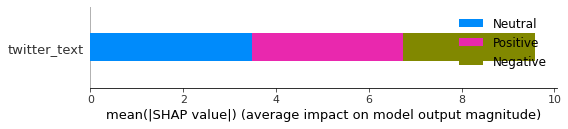

In [0]:
# Set this flag to True and re-run the notebook to see the SHAP plots
shap_enabled = True

if shap_enabled:
    from shap import KernelExplainer, summary_plot
    # Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
    train_sample = X_train.sample(n=min(100, X_train.shape[0]))

    # Sample some rows from the validation set to explain. Increase the sample size for more thorough results.
    example = X_val.sample(n=min(10, X_val.shape[0]))

    # Use Kernel SHAP to explain feature importance on the example from the validation set.
    predict = lambda x: model.predict_proba(pd.DataFrame(x, columns=X_train.columns))
    explainer = KernelExplainer(predict, train_sample, link="logit")
    shap_values = explainer.shap_values(example, l1_reg=False)
    summary_plot(shap_values, example, class_names=model.classes_)

## Model run id
Generating model run id to predict sentiment score

In [0]:
# Run id for the generated model
model_run_id = (f"{ mlflow_run.info.run_id }")
print(model_run_id)

7998543213ed4db0aa48a5ddcc23ed48


Save the generated model_run_id in a view, so that it can be used from another notebook

In [0]:
# creating a view to load the model run id in another notebook
val = model_run_id

spark.sql(
    """
       CREATE or REPLACE VIEW  mlview
        AS SELECT "{0}" as value
    """.format(val)
)

Out[18]: DataFrame[]